DATA EXTRACTION / WEB SCRAPING

In [ ]:
import json
import csv

# Load HAR file
def load_har_file(har_file_path):
    with open(har_file_path, 'r', encoding='utf-8') as file:
        har_data = json.load(file)
    return har_data

# Extract information and write to CSV
def har_to_csv(har_file_path, csv_file_path):
    har_data = load_har_file(har_file_path)

    # Open CSV file for writing
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)

        # Write header
        csv_writer.writerow(['Method', 'URL', 'Status', 'Time (ms)'])

        # Loop through each entry in the HAR file
        for entry in har_data['log']['entries']:
            request = entry['request']
            response = entry['response']
            timings = entry['timings']

            # Extract data
            method = request['method']
            url = request['url']
            status = response['status']
            time = timings['wait']

            # Write row to CSV
            csv_writer.writerow([method, url, status, time])

# Example usage
har_file_path = "C:\\Users\\Admin\\Downloads\\chairs.har"  # Specify your HAR file path
csv_file_path = "C:\\Users\\Admin\\Downloads\\chairs.csv"   # Specify output CSV file path
har_to_csv(har_file_path, csv_file_path)

print("HAR file successfully converted to CSV!")


In [ ]:
import pandas as pd
df = pd.read_csv("C:\\Users\\Admin\\Downloads\\chairs.csv")
df.head()

In [ ]:
import pandas as pd
import os
import requests

# Function to download images from URLs
def download_images_from_urls(df, url_column, download_folder):
    # Create folder if it doesn't exist
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        url = row[url_column]

        try:
            # Send a GET request to the URL
            response = requests.get(url, stream=True)

            # Check if the response content type is an image
            if 'image' in response.headers['Content-Type']:
                # Get the image name from the URL or use a default naming scheme
                image_name = f"image_{index + 1}.jpg"  # You can customize the naming format

                # Define the image path
                image_path = os.path.join(download_folder, image_name)

                # Write the image to file
                with open(image_path, 'wb') as image_file:
                    for chunk in response.iter_content(1024):
                        image_file.write(chunk)

                print(f"Downloaded: {image_name}")
            else:
                print(f"URL does not point to an image: {url}")
        except Exception as e:
            print(f"Error downloading {url}: {e}")

# Example usage
# Assume you have a CSV file with a column named 'url'
df = pd.read_csv('C:\\Users\\Admin\\Downloads\\chairs.csv')  # Replace with your CSV file path
download_folder = 'C:\\Users\\Admin\\Downloads\\chairs'  # Folder to save the images
url_column = 'URL'  # Replace with the column name that contains the URLs

download_images_from_urls(df, url_column, download_folder)

print("Image downloading complete!")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.decomposition import PCA

IMAGE FOLDER EXTRACTION FROM DRIVE

---



In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os

zip_path = ''  # Update this with your file's path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')


IMAGES IN DATAFRAME

---



In [ ]:
beds_folder = '/Users/mariyajeeranwala/Desktop/ikea/beds'

sofa_folder = '/Users/mariyajeeranwala/Desktop/ikea/sofa'

chairs_folder = '/Users/mariyajeeranwala/Desktop/ikea/chairs'

tables_folder = '/Users/mariyajeeranwala/Desktop/ikea/tables'

shelving_folder = '/Users/mariyajeeranwala/Desktop/ikea/shelving'

wadrobe_folder = '/Users/mariyajeeranwala/Desktop/ikea/wadrobe'

In [ ]:
# Function to load images from a folder and create a DataFrame
def load_images(folder_path):
    image_paths = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is not None:  # Check if image was loaded successfully
                image_paths.append(image_path)
    return pd.DataFrame({'image_path': image_paths})

# Load images from each folder
beds_df = load_images(beds_folder)
sofa_df = load_images(sofa_folder)
chairs_df = load_images(chairs_folder)
tables_df = load_images(tables_folder)
shelving_df = load_images(shelving_folder)
wadrobe_df = load_images(wadrobe_folder)


# Combine DataFrames
combined_df = pd.concat([beds_df, sofa_df, chairs_df, tables_df, shelving_df, wadrobe_df])
print(combined_df.shape)

DUPLICATION REMOVAL

---



In [ ]:
# Remove duplicate images based on image content
def remove_duplicates(df):
    image_hashes = []
    unique_df = pd.DataFrame()
    for index, row in df.iterrows():
        image_path = row['image_path']
        image = cv2.imread(image_path)
        image_hash = hash(image.tobytes())
        if image_hash not in image_hashes:
            image_hashes.append(image_hash)
            unique_df = pd.concat([unique_df, row.to_frame().T], ignore_index=True)
    return unique_df

# Remove duplicates from the combined DataFrame
combined_df = remove_duplicates(combined_df)
print(combined_df.shape)

IMAGE PROCESSING

---



VISUAL TRANSFORMER IMAGE PROCESSING

In [ ]:
combined_df = combined_df.applymap(lambda x: [x] if isinstance(x, int) else x)

In [ ]:
from transformers import AutoProcessor, AutoImageProcessor, ViTMAEModel
import torch
import torch.nn as nn

# Define the FeatureExtractor class
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")

    def forward(self, inputs):
        inputs.pop('image_name', None)
        outputs = self.model(**inputs)
        return torch.sum(outputs.last_hidden_state, dim=1)

# Load the processor
processor = AutoProcessor.from_pretrained("facebook/vit-mae-base")

# Function to process each image and extract features
def extract_features_from_df(row, feature_extractor, processor):
    try:
        # Load the image from the path
        image = Image.open(row['image_path'])

        # Preprocess the image
        inputs = processor(images=image, return_tensors="pt")

        # Extract features
        with torch.no_grad():  # For inference
            features = feature_extractor(inputs)

        # Convert tensor to list (or numpy array) if you want to store it in a DataFrame
        return features.squeeze().tolist()

    except Exception as e:
        print(f"Error processing image {row['image_path']}: {e}")
        return None

# Example DataFrame with image paths
df = pd.DataFrame(combined_df['image_path'])
# Instantiate the FeatureExtractor
feature_extractor = FeatureExtractor()

# Apply the feature extraction to each row
df['features'] = df.apply(lambda row: extract_features_from_df(row, feature_extractor, processor), axis=1)

# Check the output DataFrame with extracted features
print(df.head())

NULL REMOVAL

In [ ]:
# Drop rows where 'features' column contains NaN or None
df = df.dropna(subset=['features'])

# Ensure 'features' column contains lists (or valid feature data)
df = df[df['features'].apply(lambda x: isinstance(x, list))]

# Convert the list of features into a new DataFrame (expand each list element into its own column)
features_df = pd.DataFrame(df['features'].to_list())

# Reset the index of both DataFrames to ensure unique indices
df = df.reset_index(drop=True)
features_df = features_df.reset_index(drop=True)

# Concatenate both DataFrames along the columns
df = pd.concat([df, features_df], axis=1)

# Check the updated DataFrame
print(df.head())

In [ ]:
df = df.drop(columns=['Unnamed: 0'])
df.columns = df.columns.astype(str)

PCA

---



In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # Keep components that explain 95% of the variance
principal_components = pca.fit_transform(df)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data = principal_components)

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

[0.91816356 0.01863835 0.01282247 0.00847042]


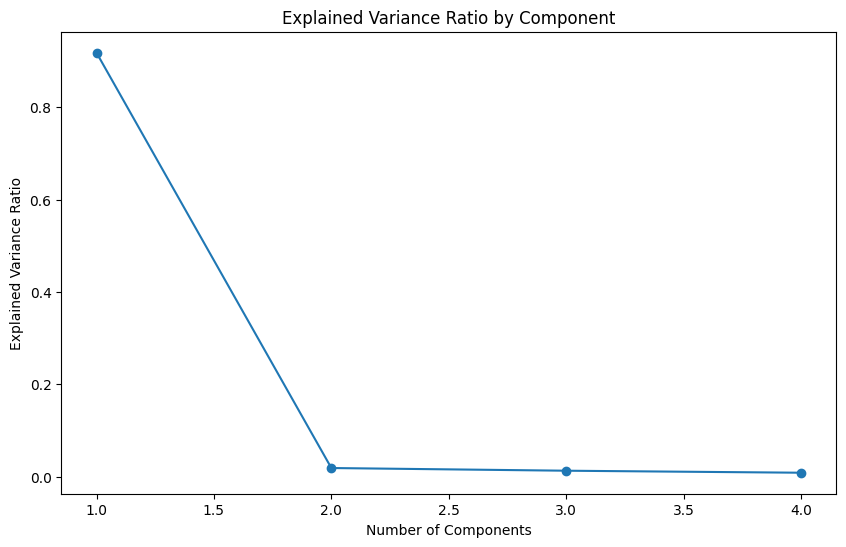

In [ ]:
# Visualize   the explained variance ratio
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Component')
plt.show()

In [ ]:
principal_df.describe()

,0,1,2,3
count,8.483000e+03,8.483000e+03,8.483000e+03,8.483000e+03
mean,-1.372337e-12,-3.773926e-14,-9.499143e-14,-8.469891e-15
std,5.391361e+02,7.681429e+01,6.371243e+01,5.178344e+01
min,-2.039960e+03,-2.724464e+02,-3.707500e+02,-2.949342e+02
25%,-3.982310e+02,-5.793451e+01,-4.525542e+01,-2.940709e+01
50%,1.241870e+02,-2.045654e+00,3.076175e+00,-4.944913e+00
75%,4.466897e+02,5.710663e+01,4.852783e+01,2.026418e+01
max,8.220050e+02,2.345171e+02,2.383134e+02,5.525545e+02


In [ ]:
principal_df.columns = principal_df.columns.astype(str)

In [ ]:
principal_df.columns

Index(['0', '1', '2', '3'], dtype='object')

In [ ]:
principal_df1=principal_df[['0','1','2','3']]                     # CREATE DUPLICATE DATAFRAME FOR TRAINING VARIABLES

CLUSTERING ANALYSIS



1.  KMEANS++



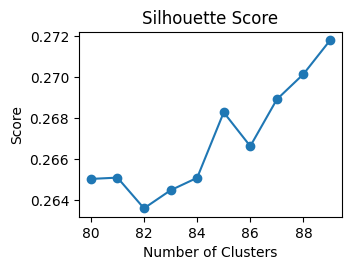

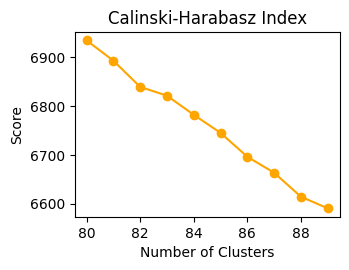

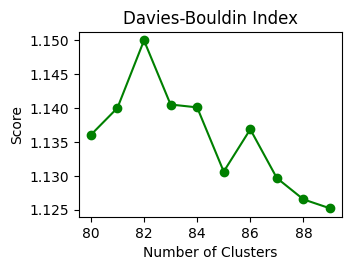

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
cluster_range = range(80,90)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    principal_df['cluster'] = kmeans.fit_predict(principal_df1)

    # Calculate Silhouette Score
    silhouette_score_value = silhouette_score(principal_df, principal_df['cluster'])
    silhouette_scores.append(silhouette_score_value)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score_value = calinski_harabasz_score(principal_df, principal_df['cluster'])
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    # Calculate Davies-Bouldin Index
    davies_bouldin_score_value = davies_bouldin_score(principal_df, principal_df['cluster'])
    davies_bouldin_scores.append(davies_bouldin_score_value)


import matplotlib.pyplot as plt


plt.subplot(2, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Plotting Calinski-Harabasz Index
plt.subplot(2, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='orange')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Plotting Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o', color='green')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()



In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=87, init='k-means++', random_state=42)
principal_df['cluster'] = kmeans.fit_predict(principal_df1)

from collections import Counter

cluster_sizes = Counter(principal_df['cluster'])

for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 200:
        print(f"Cluster {cluster_label} has {size} points")

Cluster 79 has 7 points
Cluster 29 has 238 points
Cluster 28 has 9 points


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.2689087904908815
6663.3863481302
1.1296520042049414



2.   KMEANS MINIBATCH



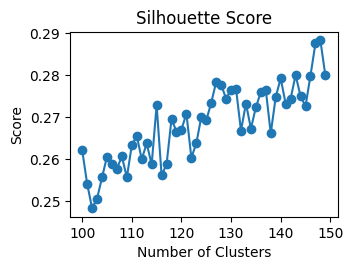

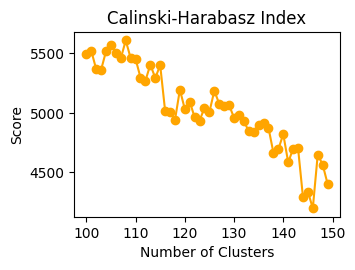

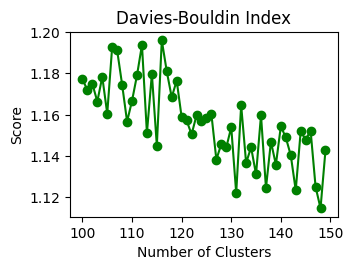

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
cluster_range = range(100,150)

for n_clusters in cluster_range:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100, random_state=42)
    principal_df['cluster'] = kmeans.fit_predict(principal_df1)

    # Calculate Silhouette Score
    silhouette_score_value = silhouette_score(principal_df, principal_df['cluster'])
    silhouette_scores.append(silhouette_score_value)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score_value = calinski_harabasz_score(principal_df, principal_df['cluster'])
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    # Calculate Davies-Bouldin Index
    davies_bouldin_score_value = davies_bouldin_score(principal_df, principal_df['cluster'])
    davies_bouldin_scores.append(davies_bouldin_score_value)


import matplotlib.pyplot as plt


plt.subplot(2, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Plotting Calinski-Harabasz Index
plt.subplot(2, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='orange')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Plotting Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o', color='green')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=115, batch_size=100, random_state=42)
principal_df['cluster'] = kmeans.fit_predict(principal_df1)


from collections import Counter
cluster_sizes = Counter(principal_df['cluster'])

for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 200:
        print(f"Cluster {cluster_label} has {size} points")

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.2729012450134587
5399.455272589309
1.1450430351660765


In [ ]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.5 MB/s eta 0:00:00



3.  KMEDIOD






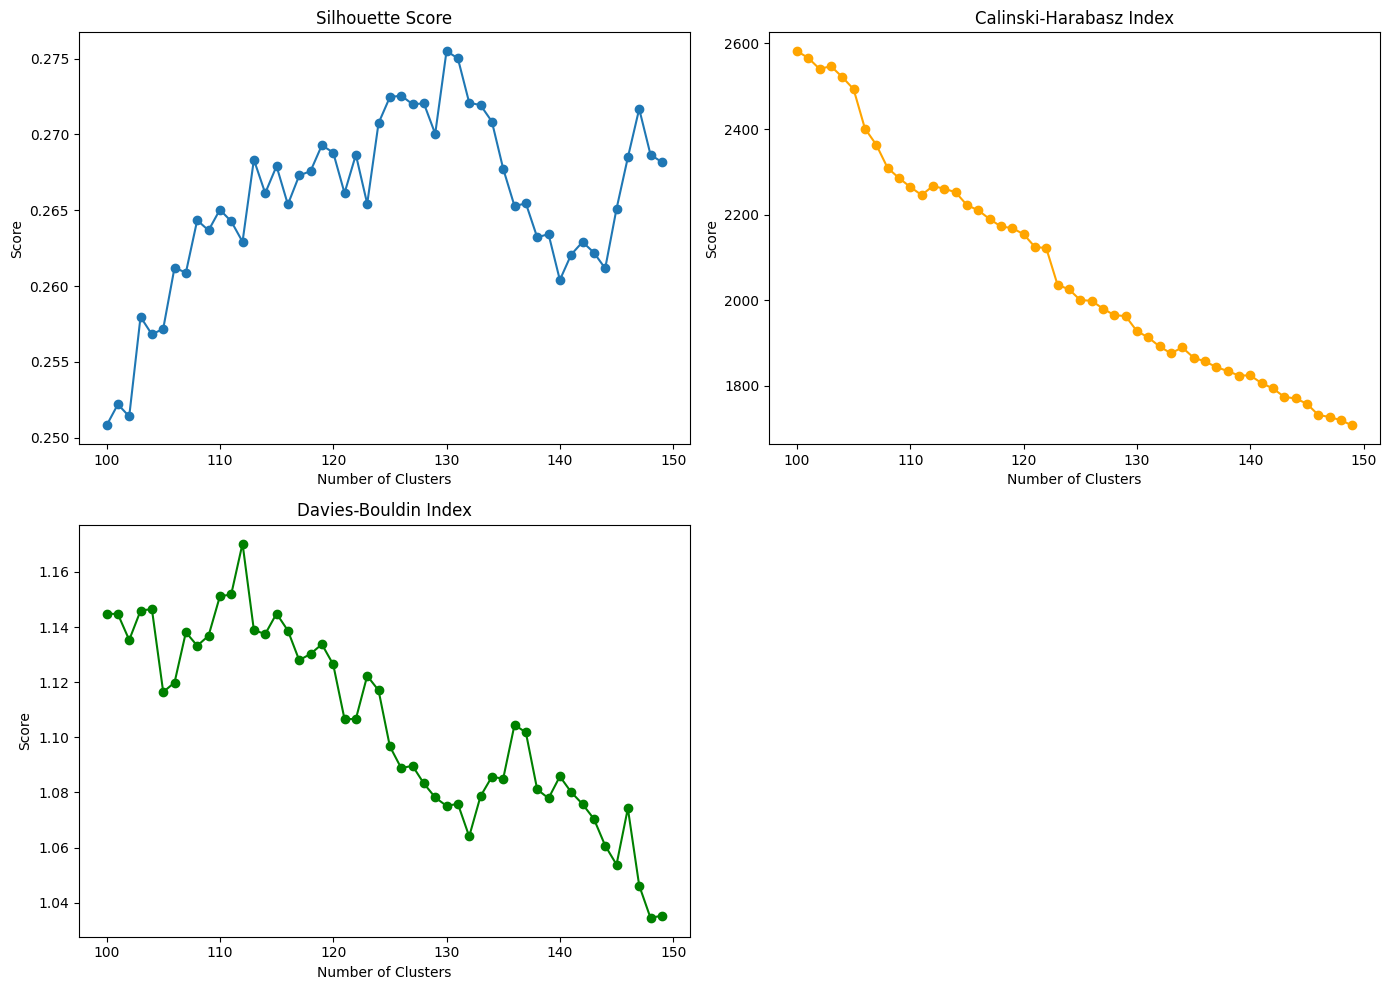

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn_extra.cluster import KMedoids

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
cluster_range = range(100,150)

# Step 2: Calculate inertia for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMedoids(n_clusters=n_clusters, random_state=42)
    principal_df['cluster'] = kmeans.fit_predict(principal_df1)

    # Calculate Silhouette Score
    silhouette_score_value = silhouette_score(principal_df, principal_df['cluster'])
    silhouette_scores.append(silhouette_score_value)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score_value = calinski_harabasz_score(principal_df, principal_df['cluster'])
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    # Calculate Davies-Bouldin Index
    davies_bouldin_score_value = davies_bouldin_score(principal_df, principal_df['cluster'])
    davies_bouldin_scores.append(davies_bouldin_score_value)


# Now you can plot the results for each index
import matplotlib.pyplot as plt
# Plotting the evaluation metrics
plt.figure(figsize=(14, 10))

# Plotting Silhouette Score
plt.subplot(2, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Plotting Calinski-Harabasz Index
plt.subplot(2, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='orange')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Plotting Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o', color='green')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn_extra.cluster import KMedoids
kmeans = KMedoids(n_clusters=50, random_state=42)
principal_df['cluster'] = kmeans.fit_predict(principal_df)

from collections import Counter
cluster_sizes = Counter(principal_df['cluster'])
for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 200:
        print(f"Cluster {cluster_label} has {size} points")

Cluster 30 has 436 points
Cluster 14 has 237 points
Cluster 42 has 855 points
Cluster 45 has 986 points
Cluster 17 has 875 points
Cluster 20 has 234 points
Cluster 23 has 499 points
Cluster 39 has 527 points
Cluster 5 has 241 points
Cluster 7 has 324 points
Cluster 48 has 377 points
Cluster 10 has 370 points
Cluster 35 has 9 points
Cluster 47 has 6 points
Cluster 43 has 10 points
Cluster 9 has 10 points


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.22812109117164547
3484.149359710491
1.3713720984315274




4.  GAUSSIAN MIXTURE MODEL



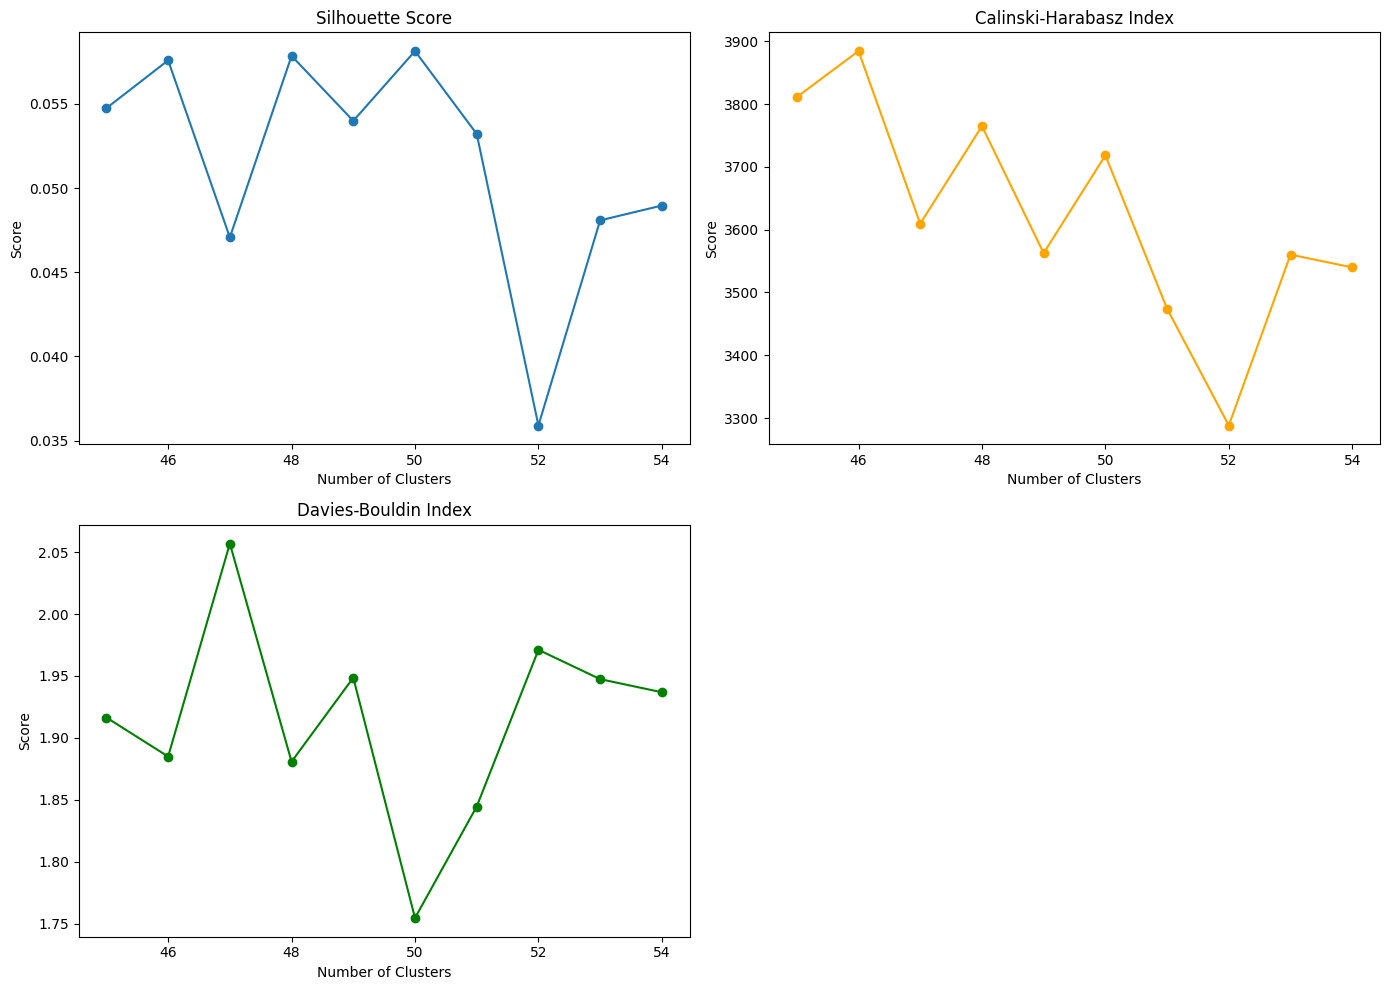

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming 'principal_df' is your DataFrame with features
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
cluster_range = range(45,55)

for n_clusters in cluster_range:
    # Create and fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    principal_df['cluster'] = gmm.fit_predict(principal_df1)

    # Calculate Silhouette Score
    silhouette_score_value = silhouette_score(principal_df, principal_df['cluster'])
    silhouette_scores.append(silhouette_score_value)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_score_value = calinski_harabasz_score(principal_df, principal_df['cluster'])
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    # Calculate Davies-Bouldin Index
    davies_bouldin_score_value = davies_bouldin_score(principal_df, principal_df['cluster'])
    davies_bouldin_scores.append(davies_bouldin_score_value)

# Plotting the evaluation metrics
plt.figure(figsize=(14, 10))

# Plotting Silhouette Score
plt.subplot(2, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Plotting Calinski-Harabasz Index
plt.subplot(2, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='orange')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Plotting Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.plot(cluster_range, davies_bouldin_scores, marker='o', color='green')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=50, random_state=42)
principal_df['cluster'] = gmm.fit_predict(principal_df1)

from collections import Counter
cluster_sizes = Counter(principal_df['cluster'])
for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 200:
        print(f"Cluster {cluster_label} has {size} points")

Cluster 10 has 319 points
Cluster 33 has 290 points
Cluster 28 has 241 points
Cluster 43 has 364 points
Cluster 1 has 243 points
Cluster 31 has 233 points
Cluster 48 has 353 points
Cluster 16 has 311 points
Cluster 20 has 235 points
Cluster 12 has 405 points
Cluster 11 has 212 points
Cluster 19 has 284 points
Cluster 7 has 283 points
Cluster 45 has 226 points
Cluster 23 has 224 points
Cluster 37 has 288 points


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.05812920960056145
3718.473245259278
1.754710092129899




5.   DBSCAN




In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)  # Convert 'features' column to list before scaling

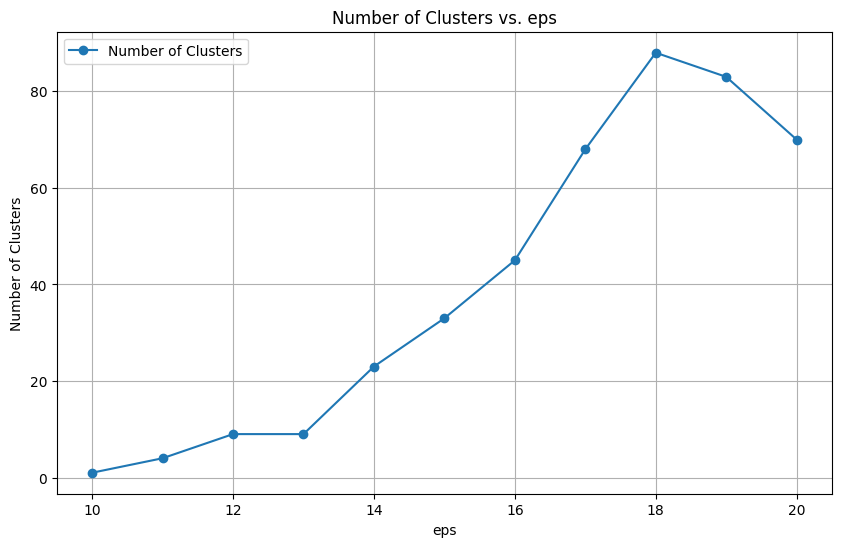

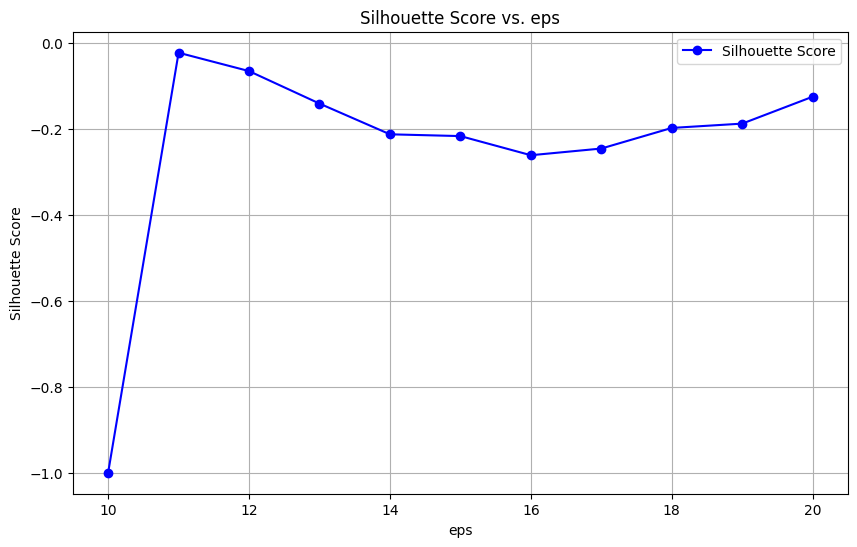

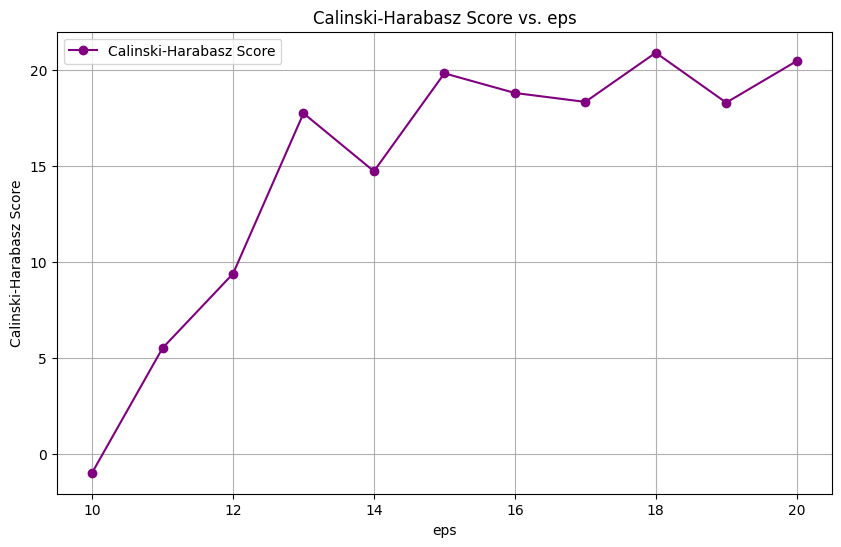

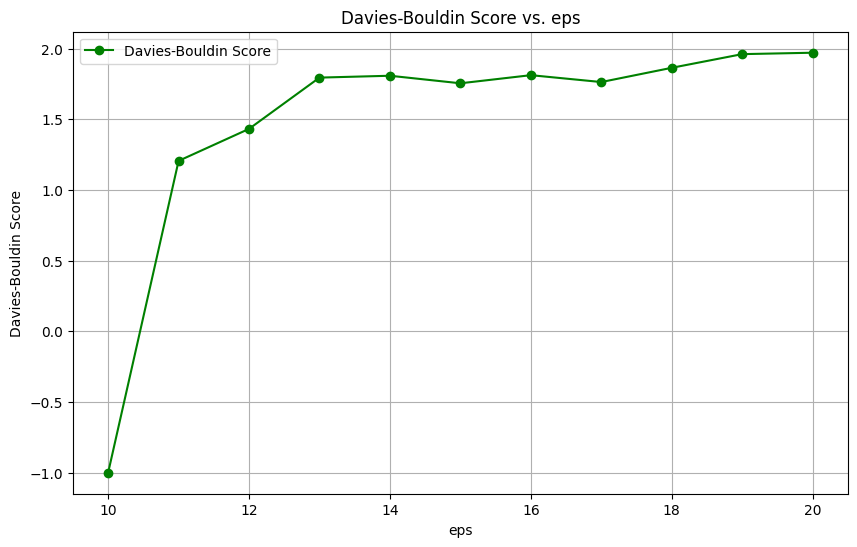

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Sample range for eps values
eps_values = np.arange(10, 21, 1)

# Initialize lists to store results
num_clusters = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

for eps in eps_values:
    # Fit DBSCAN model with the current eps
    dbscan = DBSCAN(eps=eps, min_samples=5)
    df['cluster'] = dbscan.fit_predict(scaled_features)
    labels = df['cluster']

    # Calculate the number of clusters (excluding noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters.append(n_clusters)

    # Calculate metrics only if there is more than one cluster
    if n_clusters > 1:
        silhouette_scores.append(silhouette_score(scaled_features, labels))
        calinski_harabasz_scores.append(calinski_harabasz_score(scaled_features, labels))
        davies_bouldin_scores.append(davies_bouldin_score(scaled_features, labels))
    else:
        # Append default values when no valid clustering exists
        silhouette_scores.append(-1)
        calinski_harabasz_scores.append(-1)
        davies_bouldin_scores.append(-1)

# Plotting Number of Clusters vs. eps (Elbow Plot)
plt.figure(figsize=(10, 6))
plt.plot(eps_values, num_clusters, marker='o', label='Number of Clusters')
plt.title('Number of Clusters vs. eps')
plt.xlabel('eps')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Silhouette Score vs. eps
plt.figure(figsize=(10, 6))
plt.plot(eps_values, silhouette_scores, marker='o', color='blue', label='Silhouette Score')
plt.title('Silhouette Score vs. eps')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Calinski-Harabasz Score vs. eps
plt.figure(figsize=(10, 6))
plt.plot(eps_values, calinski_harabasz_scores, marker='o', color='purple', label='Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs. eps')
plt.xlabel('eps')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Davies-Bouldin Score vs. eps
plt.figure(figsize=(10, 6))
plt.plot(eps_values, davies_bouldin_scores, marker='o', color='green', label='Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs. eps')
plt.xlabel('eps')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Apply DBSCAN with eps = 18
dbscan = DBSCAN(eps=18, min_samples=10)
df['cluster'] = dbscan.fit_predict(scaled_features)

# Check the cluster labels (number of samples in each cluster)
print(df['cluster'].value_counts())

cluster
-1     5632
 0     1798
 16     695
 4       39
 2       33
 22      30
 3       24
 14      21
 6       20
 5       18
 20      17
 8       14
 21      14
 10      13
 23      12
 12      12
 13      11
 1       11
 11      11
 17      11
 9       10
 19      10
 7       10
 18       8
 24       5
 15       4
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print(silhouette_score(df, df['cluster']))
print(calinski_harabasz_score(df, df['cluster']))
print(davies_bouldin_score(df, df['cluster']))

-0.5783190790522349
81.15051522005159
2.6826642652830737


In [ ]:
from collections import Counter
cluster_sizes = Counter(df['cluster'])
for cluster_label, size in cluster_sizes.items():
    if size < 11:
        print(f"Cluster {cluster_label} has {size} points")
    if size > 200:
        print(f"Cluster {cluster_label} has {size} points")

Cluster 0 has 1798 points
Cluster -1 has 5632 points
Cluster 7 has 10 points
Cluster 15 has 4 points
Cluster 9 has 10 points
Cluster 18 has 8 points
Cluster 19 has 10 points
Cluster 16 has 695 points
Cluster 24 has 5 points




6.   AFFINITY PROPAGATION



In [ ]:
from sklearn.cluster import AffinityPropagation

# Create an AffinityPropagation object
af = AffinityPropagation(damping=0.9)

# Fit the model to the data
af.fit(principal_df1)

# Add the cluster labels to your DataFrame
principal_df['cluster'] = af.labels_

In [ ]:
print(principal_df['cluster'].value_counts())

cluster
7     278
12    222
8     212
13    188
1     184
     ... 
2      19
78     15
23     12
61      7
0       6
Name: count, Length: 80, dtype: int64


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

0.243110342673767
6812.377824662508
1.1868246367403064


7. BIRCH

In [ ]:
from sklearn.cluster import Birch

# Create a Birch object
brc = Birch(threshold=0.5, branching_factor=50)

# Fit the model to the data
brc.fit(principal_df1)

# Add the cluster labels to your DataFrame
principal_df['cluster'] = labels

In [ ]:
print(principal_df['cluster'].value_counts())

cluster
 0     4841
-1     2651
 5      134
 6       97
 61      46
       ... 
 43       5
 42       5
 19       4
 53       4
 54       4
Name: count, Length: 70, dtype: int64


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print(silhouette_score(principal_df, principal_df['cluster']))
print(calinski_harabasz_score(principal_df, principal_df['cluster']))
print(davies_bouldin_score(principal_df, principal_df['cluster']))

-0.6174465928810741
75.51011141530692
5.661674472230315


KMEANS ++ CLUSTERING CHOSEN AS FINAL

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame and 'features' contains the extracted features
# Replace 'df' with the actual DataFrame you are using

# Standardize features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df['features'].to_list())  # Convert 'features' column to list before scaling

# Set number of clusters for KMeans
k = 77

# Initialize KMeans with k-means++ initialization and fit the model
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)  # Predict clusters and assign to DataFrame

# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_features, df['cluster']) if k > 1 else -1

# Display silhouette score
print(f'Silhouette Score for k={k}:', silhouette_avg)

# Check the cluster labels (number of samples in each cluster)
print(df['cluster'].value_counts())

# Plot the silhouette score (only one value here since k is fixed)
plt.figure(figsize=(6, 4))
plt.bar([k], [silhouette_avg], color='green', label='Silhouette Score')
plt.title('Silhouette Score for KMeans (k=77)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

RECOMMENDATION SYSTEM

In [ ]:
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

random_index = random.choice(df.index)
random_image_features = df.loc[random_index, 'features']
random_cluster = df.loc[random_index, 'cluster']


same_cluster_df = df[df['cluster'] == random_cluster]
cluster_features = np.array(same_cluster_df['features'].tolist())

similarities = cosine_similarity([random_image_features], cluster_features).flatten()

most_similar_indices = similarities.argsort()[-11:-1]

selected_image_path = df.loc[random_index, 'image_path']
similar_image_paths = same_cluster_df.iloc[most_similar_indices]['image_path'].tolist()

def display_images(image_paths, title):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_images([selected_image_path], "Selected Image")

display_images(similar_image_paths, "10 Most Similar Images")
